In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import MobileNet_V2_Weights

import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
import yaml
import json
from tqdm import tqdm
import sys

In [12]:
# ========== КОНФИГУРАЦИЯ ==========
class Config:
    def __init__(self):
        # Пути
        self.data_dir = Path("data")
        self.model_dir = Path("models")
        self.metrics_dir = Path("metrics")
        
        # Параметры данных
        self.image_size = (224, 224)
        self.batch_size = 16  # Меньше для CPU
        self.num_workers = 0  # 0 для Windows чтобы избежать ошибок
        
        # Параметры модели
        self.model_name = "mobilenet_v2"
        self.num_classes = 5
        self.pretrained = True
        
        # Параметры обучения
        self.learning_rate = 0.001
        self.epochs = 10
        self.patience = 5
        
        # Устройство
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Создаем директории
        self.model_dir.mkdir(exist_ok=True)
        self.metrics_dir.mkdir(exist_ok=True)

    
        with open('../data/processed/class_info.yaml', 'r') as f:
            class_info = yaml.safe_load(f)
        self.class_names = class_info['class_names']



In [13]:
class BirdDataset(Dataset):
    def __init__(self, csv_path, transform=None, class_info_path=None):
        self.df = pd.read_csv(csv_path)
        self.transform = transform
        
        # Загружаем информацию о классах
        if class_info_path and Path(class_info_path).exists():
            with open(class_info_path, 'r') as f:
                class_info = yaml.safe_load(f)
            self.class_to_idx = class_info['class_to_idx']
            self.idx_to_class = class_info['idx_to_class']
            self.class_names = class_info['class_names']
        else:
            # Создаем mapping классов
            self.class_names = sorted(self.df['class_name'].unique())
            self.class_to_idx = {cls: idx for idx, cls in enumerate(self.class_names)}
            self.idx_to_class = {idx: cls for idx, cls in enumerate(self.class_names)}
        
        # Проверяем файлы
        self.valid_indices = []
        for idx in range(len(self.df)):
            path = Path(self.df.iloc[idx]['local_path'])
            if path.exists():
                self.valid_indices.append(idx)
            else:
                # Пробуем альтернативный путь
                alt_path = Path(f"C:/Users/Lada/Documents/DS/naturalist/data/raw/{self.df.iloc[idx]['class_name']}/{self.df.iloc[idx]['id']}.jpg")
                if alt_path.exists():
                    # Обновляем путь
                    self.df.at[idx, 'local_path'] = str(alt_path)
                    self.valid_indices.append(idx)
        
        print(f"  Валидных изображений: {len(self.valid_indices)}/{len(self.df)}")
    
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        # Получаем реальный индекс
        real_idx = self.valid_indices[idx]
        row = self.df.iloc[real_idx]
        image_path = Path(row['local_path'])
        class_name = row['class_name']
        
        # Загружаем изображение
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Ошибка загрузки {image_path}: {e}")
            # Черное изображение как заглушка
            image = Image.new('RGB', (224, 224), color='black')
        
        # Трансформации
        if self.transform:
            image = self.transform(image)
        
        # Метка
        label = self.class_to_idx[class_name]
        
        return image, label

In [14]:
# ========== ТРАНСФОРМАЦИИ ==========
def get_transforms(image_size=(224, 224), augment=False):
    """Возвращает трансформации для изображений"""
    if augment:
        # Для тренировочных данных
        return transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomCrop(image_size),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])
    else:
        # Для валидации и теста
        return transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])



In [15]:
# ========== МОДЕЛЬ ==========
class BirdClassifier(nn.Module):
    def __init__(self, num_classes=5, model_name='mobilenet_v2', pretrained=True):
        super().__init__()
        self.model_name = model_name
        
        if model_name == 'mobilenet_v2':
            # MobileNetV2
            weights = MobileNet_V2_Weights.DEFAULT if pretrained else None
            self.backbone = models.mobilenet_v2(weights=weights)
            
            # Заменяем классификатор
            num_features = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Sequential(
                nn.Dropout(p=0.2),
                nn.Linear(num_features, num_classes)
            )
        else:
            raise ValueError(f"Модель {model_name} не поддерживается")
    
    def forward(self, x):
        return self.backbone(x)



In [16]:
# ========== ТРЕНЕР ==========
class Trainer:
    def __init__(self, model, config):
        self.model = model
        self.config = config
        self.device = config.device
        self.model.to(self.device)
        
        # Функция потерь и оптимизатор
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        
        # История
        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': []
        }
        self.best_val_acc = 0.0
    
    def train_epoch(self, train_loader):
        self.model.train()
        total_loss, correct, total = 0, 0, 0
        
        pbar = tqdm(train_loader, desc="Training")
        for images, labels in pbar:
            images, labels = images.to(self.device), labels.to(self.device)
            
            # Forward pass
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            
            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            # Статистика
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Обновляем progress bar
            pbar.set_postfix({
                'loss': f"{total_loss/len(train_loader):.4f}",
                'acc': f"{100.*correct/total:.2f}%"
            })
        
        return total_loss/len(train_loader), 100.*correct/total
    
    def validate(self, data_loader):
        self.model.eval()
        total_loss, correct, total = 0, 0, 0
        
        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                
                total_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        return total_loss/len(data_loader), 100.*correct/total
    
    def train(self, train_loader, val_loader):
        print(f"Устройство: {self.device}")
        print(f"Батч: {self.config.batch_size}, Эпох: {self.config.epochs}")
        
        patience_counter = 0
        
        for epoch in range(self.config.epochs):
            print(f"\nЭпоха {epoch+1}/{self.config.epochs}")
            
            # Обучение
            train_loss, train_acc = self.train_epoch(train_loader)
            
            # Валидация
            val_loss, val_acc = self.validate(val_loader)
            
            # Сохраняем историю
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            
            # Сохраняем лучшую модель
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.save_model('best_model.pth')
                patience_counter = 0
                print(f" Лучшая модель: {val_acc:.2f}%")
            else:
                patience_counter += 1
                print(f" Нет улучшения {patience_counter}/{self.config.patience}")
            
            print(f"Train: loss={train_loss:.4f}, acc={train_acc:.2f}%")
            print(f"Val: loss={val_loss:.4f}, acc={val_acc:.2f}%")
            
            # Early stopping
            if patience_counter >= self.config.patience:
                print(f"\nEarly stopping")
                break
        
        # Сохраняем последнюю модель
        self.save_model('last_model.pth')
        
        return self.history


    def save_model(self, filename):
        """Сохраняет модель без сложных зависимостей"""
        model_path = self.config.model_dir / filename
    
        # Сохраняем только самое необходимое
        torch.save({
        'model_state_dict': self.model.state_dict(),
        'class_names': self.config.class_names if hasattr(self.config, 'class_names') else [],
        'model_name': self.config.model_name,
        'num_classes': self.config.num_classes
        }, model_path)



In [17]:
# ========== ОСНОВНАЯ ФУНКЦИЯ ==========
def main():
    # Конфигурация
    config = Config()
    print("="*50)
    print("НАЧАЛО ОБУЧЕНИЯ")
    print("="*50)
    
    # Трансформации
    train_transform = get_transforms(config.image_size, augment=True)
    val_transform = get_transforms(config.image_size, augment=False)
    
    # Датасеты
    print("\nЗагрузка данных...")
    train_dataset = BirdDataset(
        '../data/processed/train.csv',
        transform=train_transform,
        class_info_path='../data/processed/class_info.yaml'
    )
    
    val_dataset = BirdDataset(
        '../data/processed/val.csv',
        transform=val_transform,
        class_info_path='../data/processed/class_info.yaml'
    )
    
    print(f"Train: {len(train_dataset)} изображений")
    print(f"Val: {len(val_dataset)} изображений")
    
    # Даталоадеры
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers
    )
    
    # Модель
    print(f"\nСоздание модели {config.model_name}...")
    model = BirdClassifier(
        num_classes=config.num_classes,
        model_name=config.model_name,
        pretrained=config.pretrained
    )
    
    # Обучение
    trainer = Trainer(model, config)
    history = trainer.train(train_loader, val_loader)
    
    # Тестирование
    print("\n" + "="*50)
    print("ТЕСТИРОВАНИЕ")
    print("="*50)
    
    test_dataset = BirdDataset(
        '../data/processed/test.csv',
        transform=val_transform,
        class_info_path='../data/processed/class_info.yaml'
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers
    )
    
    test_loss, test_acc = trainer.validate(test_loader)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")
    
    # Сохраняем метрики
    final_metrics = {
        'best_val_accuracy': float(trainer.best_val_acc),
        'test_accuracy': float(test_acc),
        'test_loss': float(test_loss)
    }
    
    metrics_path = config.metrics_dir / 'final_metrics.json'
    with open(metrics_path, 'w') as f:
        json.dump(final_metrics, f, indent=4)
    
    print(f"\nМетрики сохранены в {metrics_path}")
    
    # Простой график точности
    try:
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss during training')
        
        plt.subplot(1, 2, 2)
        plt.plot(history['train_acc'], label='Train Accuracy')
        plt.plot(history['val_acc'], label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.title('Accuracy during training')
        
        plt.tight_layout()
        plt.savefig('metrics/training_history.png', dpi=100)
        print("График обучения сохранен в metrics/training_history.png")
        
    except ImportError:
        print("Matplotlib не установлен, пропускаем создание графиков")
    
    print("\n" + "="*50)
    print("ОБУЧЕНИЕ ЗАВЕРШЕНО!")
    print(f"Лучшая точность на валидации: {trainer.best_val_acc:.2f}%")
    print(f"Точность на тесте: {test_acc:.2f}%")
    print("="*50)



НАЧАЛО ОБУЧЕНИЯ

Загрузка данных...
  Валидных изображений: 335/335
  Валидных изображений: 77/77
Train: 335 изображений
Val: 77 изображений

Создание модели mobilenet_v2...
Устройство: cpu
Батч: 16, Эпох: 10

Эпоха 1/10


Training: 100%|██████████| 21/21 [00:27<00:00,  1.29s/it, loss=1.2339, acc=53.73%]


 Лучшая модель: 57.14%
Train: loss=1.2339, acc=53.73%
Val: loss=1.0616, acc=57.14%

Эпоха 2/10


Training: 100%|██████████| 21/21 [00:22<00:00,  1.06s/it, loss=0.7234, acc=72.84%]


 Лучшая модель: 64.94%
Train: loss=0.7234, acc=72.84%
Val: loss=1.0382, acc=64.94%

Эпоха 3/10


Training: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it, loss=0.5664, acc=80.60%]


 Нет улучшения 1/5
Train: loss=0.5664, acc=80.60%
Val: loss=1.0432, acc=64.94%

Эпоха 4/10


Training: 100%|██████████| 21/21 [00:23<00:00,  1.12s/it, loss=0.5444, acc=81.79%]


 Нет улучшения 2/5
Train: loss=0.5444, acc=81.79%
Val: loss=1.0964, acc=64.94%

Эпоха 5/10


Training: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it, loss=0.4234, acc=86.27%]


 Нет улучшения 3/5
Train: loss=0.4234, acc=86.27%
Val: loss=0.9164, acc=64.94%

Эпоха 6/10


Training: 100%|██████████| 21/21 [00:23<00:00,  1.14s/it, loss=0.2980, acc=90.15%]


 Лучшая модель: 71.43%
Train: loss=0.2980, acc=90.15%
Val: loss=0.9548, acc=71.43%

Эпоха 7/10


Training: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it, loss=0.2793, acc=90.75%]


 Нет улучшения 1/5
Train: loss=0.2793, acc=90.75%
Val: loss=1.3661, acc=62.34%

Эпоха 8/10


Training: 100%|██████████| 21/21 [00:23<00:00,  1.14s/it, loss=0.3147, acc=90.45%]


 Нет улучшения 2/5
Train: loss=0.3147, acc=90.45%
Val: loss=1.0609, acc=67.53%

Эпоха 9/10


Training: 100%|██████████| 21/21 [00:24<00:00,  1.15s/it, loss=0.3003, acc=89.25%]


 Нет улучшения 3/5
Train: loss=0.3003, acc=89.25%
Val: loss=1.0901, acc=64.94%

Эпоха 10/10


Training: 100%|██████████| 21/21 [00:24<00:00,  1.15s/it, loss=0.2510, acc=91.64%]


 Нет улучшения 4/5
Train: loss=0.2510, acc=91.64%
Val: loss=1.3894, acc=62.34%

ТЕСТИРОВАНИЕ
  Валидных изображений: 73/73
Test Loss: 1.6552
Test Accuracy: 57.53%

Метрики сохранены в metrics\final_metrics.json
График обучения сохранен в metrics/training_history.png

ОБУЧЕНИЕ ЗАВЕРШЕНО!
Лучшая точность на валидации: 71.43%
Точность на тесте: 57.53%


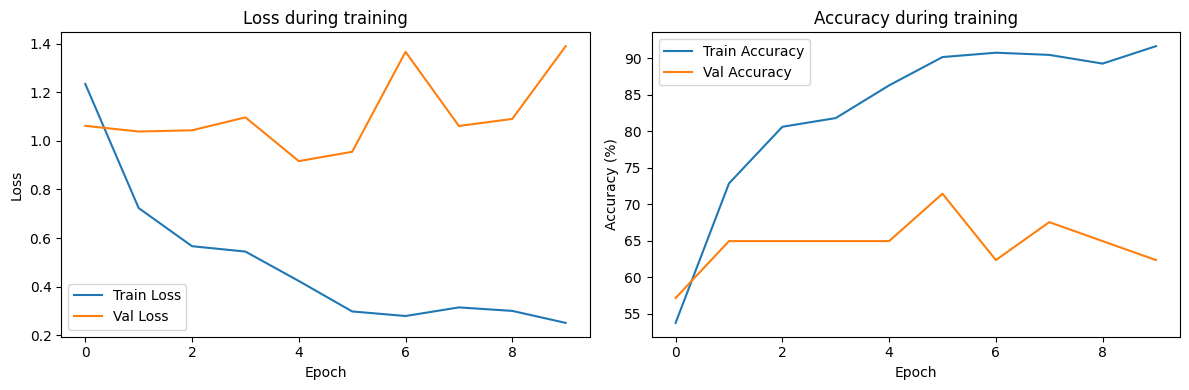

In [18]:
if __name__ == "__main__":
    main()